In [1]:
# ------------------------------------------------
# 
# overflow plotting
#
# (note, takes
# files that were generated in the scratch/cdr_
# overflow_postproc.ipynb file)
# 
# ------------------------------------------------
import os
import re
import glob

import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import TwoSlopeNorm
import matplotlib.colors as mcolors # for log-scaled colorbars
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for custom legend entries (needed for contour plot)
import numpy as np
import pandas as pd
import pickle
import xarray as xr

# set data path
datpath = "/home/tykukla/aglime-swap-cdr/scepter/process/runs/batch_postprocResults/cc-sil_psize_apprate"


# --- select the var to read in 
varin1 = "adsorbed_percCEC"
varin2 = "bulksoil"
varin3 = "solid_weightPercent"
varin4 = "soil_ph"
varin5 = "aqueous"
varsuff = "batch"
dustsp1 = "gbas"
dustsp2 = "wls"

# --- select which data to read in 
# (002, 003, 004; or 007, 008, 009)
# FEEDSTOCK 1
fertLevel_1 = "no"
idx_1 = "001"
tag_fs1 = "overflow_v1-overflow"

# 'meanAnn_shortRun_noFert_overflow-overflow_001'

In [2]:
# ---- READ IN DATA
# FEEDSTOCK 1 
datdir_1 = f"meanAnn_shortRun_{fertLevel_1}Fert_{tag_fs1}_{idx_1}"    
datloc_1 = os.path.join(datpath, datdir_1)
# read in xr datasets
dsfs1a = xr.open_dataset(os.path.join(datloc_1, f"{varin1}_{dustsp1}_{varsuff}.nc"))
dsfs1b = xr.open_dataset(os.path.join(datloc_1, f"{varin2}_{dustsp1}_{varsuff}.nc"))
dsfs1c = xr.open_dataset(os.path.join(datloc_1, f"{varin3}_{dustsp1}_{varsuff}.nc"))
dsfs1d = xr.open_dataset(os.path.join(datloc_1, f"{varin4}_{dustsp1}_{varsuff}.nc"))
dsfs1e = xr.open_dataset(os.path.join(datloc_1, f"{varin5}_{dustsp1}_{varsuff}.nc"))
# dsfs2 = xr.open_dataset(os.path.join(datloc_1, f"{varin}_{dustsp2}_{varsuff}.nc"))

dsfs1a

<xarray.Dataset> Size: 405kB
Dimensions:                  (depth: 30, time: 20, dustrate_ton_ha_yr: 3,
                              dustrad: 2)
Coordinates:
  * depth                    (depth) float64 240B 0.008333 0.025 ... 0.4917
  * time                     (time) float64 160B 0.001668 0.005001 ... 200.0
  * dustrate_ton_ha_yr       (dustrate_ton_ha_yr) float64 24B 0.0 2.0 10.0
  * dustrad                  (dustrad) int32 8B 25 50
Data variables: (12/15)
    na                       (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    no3                      (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    k                        (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    ca                       (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    mg                       (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    h                        (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    ...                       ...
    ca_coredep               (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    mg_coredep               (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    h_coredep                (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    base_saturation          (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    base_saturation_coredep  (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    int_dust_ton_ha_yr       (dustrate_ton_ha_yr, dustrad, time) float64 960B ...
Attributes:
    outfile:  prof_aq(ads%cec)

## Mg on exchange sites over time 

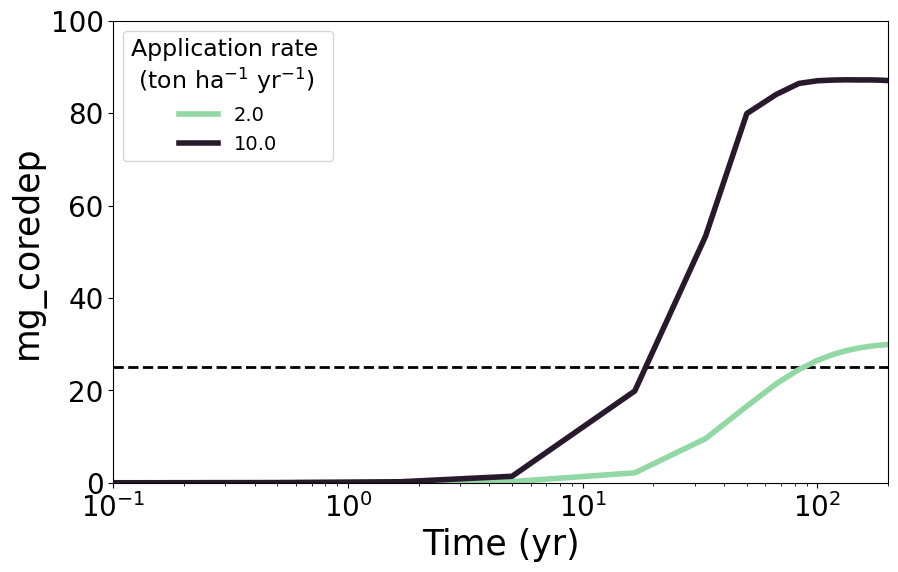

In [3]:
# --- PLOT Mg percent over time 
# set data conditions
var = "mg_coredep"
feedstock = "gbas"
dustrad = 50
depth = 0.2
logX = True
logY = False
overflow_pt = 25
dustrate_min = 2
dustrate_max = 60

# pull out the data we want 
if feedstock == dustsp1:
    dsp1 = dsfs1a.sel(dustrad = dustrad, depth=depth, method='nearest').sel(dustrate_ton_ha_yr = slice(dustrate_min, dustrate_max))[var]
elif feedstock == dustsp2:
    dsp1 = dsfs2a.sel(dustrad = dustrad, depth=depth, method='nearest').sel(dustrate_ton_ha_yr = slice(dustrate_min, dustrate_max))[var]
else:
    raise ValueError("Feedstock is not one of the prescribed dustsp!")

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dsp1 = dsp1.interpolate_na(dim='time', method='linear').copy()

# *****************************
# --- plot aesthetics
# color palette
col = cmo.deep
overflow_col = 'black'
# line
lwd = 4
lwd_overflow = 2
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = 3,12
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (0.1 if logX else 0), 200
ymin, ymax = 0, 100
# legend
fs_legtitle = 17
fs_legtxt = 14
# *****************************

# ------- PLOT ----------------
# get colormap
colors = col(np.linspace(0.2, 1, len(dsp1.dustrate_ton_ha_yr.values)))  # Generate colors for each dust

fig, ax = plt.subplots(figsize=(10,6))
ax.axhline(y=overflow_pt, color=overflow_col, linestyle="--", linewidth=lwd_overflow)
for i, dustrate in enumerate(dsp1.dustrate_ton_ha_yr.values):
    ax.plot(dsp1.time, dsp1.sel(dustrate_ton_ha_yr=dustrate), 
    label=f"{dustrate}", color=colors[i], linewidth=lwd)

ax.set_xlabel("Time (yr)", fontsize=fs_xlab)
ax.set_ylabel(var, fontsize=fs_ylab)
ax.tick_params(axis='both', labelsize=fs_tick)
(ax.set_xscale('log') if logX else "")
(ax.set_yscale('log') if logY else "")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.legend(title=f"Application rate \n {r'$(\text{ton}\ \text{ha}^{-1}\ \text{yr}^{-1})$'}", title_fontsize=fs_legtitle, fontsize=fs_legtxt, loc="best")
plt.show();




## Porosity in soils over time 

In [4]:
dsfs1b

<xarray.Dataset> Size: 520kB
Dimensions:               (depth: 30, time: 20, dustrate_ton_ha_yr: 3,
                           dustrad: 2)
Coordinates:
  * depth                 (depth) float64 240B 0.008333 0.025 ... 0.475 0.4917
  * time                  (time) float64 160B 0.001668 0.005001 ... 183.3 200.0
  * dustrate_ton_ha_yr    (dustrate_ton_ha_yr) float64 24B 0.0 2.0 10.0
  * dustrad               (dustrad) int32 8B 25 50
Data variables: (12/19)
    poro                  (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    sat                   (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    v[m/yr]               (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    m2/m3                 (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    w[m/yr]               (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    vol[m3/m3]            (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    ...                    ...
    w[m/yr]_coredep       (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    vol[m3/m3]_coredep    (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    dens[g/cm3]_coredep   (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    blk[wt%]_coredep      (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    cec[cmol/kg]_coredep  (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    int_dust_ton_ha_yr    (dustrate_ton_ha_yr, dustrad, time) float64 960B ...

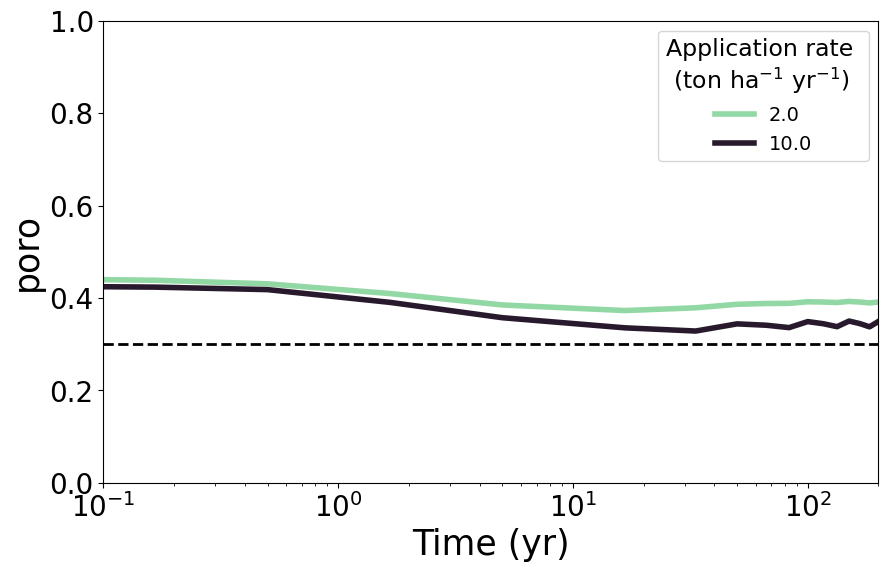

In [5]:
# --- PLOT poro percent over time 
# set data conditions
var = "poro"
feedstock = "gbas"
dustrad = 50
depth = 0.01
logX = True
logY = False
overflow_pt = 0.30
dustrate_min = 2
dustrate_max = 60

# pull out the data we want 
if feedstock == dustsp1:
    dsp1 = dsfs1b.sel(dustrad = dustrad, depth=depth, method='nearest').sel(dustrate_ton_ha_yr = slice(dustrate_min, dustrate_max))[var]
elif feedstock == dustsp2:
    dsp1 = dsfs2b.sel(dustrad = dustrad, depth=depth, method='nearest').sel(dustrate_ton_ha_yr = slice(dustrate_min, dustrate_max))[var]
else:
    raise ValueError("Feedstock is not one of the prescribed dustsp!")

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dsp1 = dsp1.interpolate_na(dim='time', method='linear').copy()

# *****************************
# --- plot aesthetics
# color palette
col = cmo.deep
overflow_col = 'black'
# line
lwd = 4
lwd_overflow = 2
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = 3,12
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (0.1 if logX else 0), 200
ymin, ymax = 0, 1
# legend
fs_legtitle = 17
fs_legtxt = 14
# *****************************

# ------- PLOT ----------------
# get colormap
colors = col(np.linspace(0.2, 1, len(dsp1.dustrate_ton_ha_yr.values)))  # Generate colors for each dust

fig, ax = plt.subplots(figsize=(10,6))
ax.axhline(y=overflow_pt, color=overflow_col, linestyle="--", linewidth=lwd_overflow)
for i, dustrate in enumerate(dsp1.dustrate_ton_ha_yr.values):
    ax.plot(dsp1.time, dsp1.sel(dustrate_ton_ha_yr=dustrate), 
    label=f"{dustrate}", color=colors[i], linewidth=lwd)

ax.set_xlabel("Time (yr)", fontsize=fs_xlab)
ax.set_ylabel(var, fontsize=fs_ylab)
ax.tick_params(axis='both', labelsize=fs_tick)
(ax.set_xscale('log') if logX else "")
(ax.set_yscale('log') if logY else "")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.legend(title=f"Application rate \n {r'$(\text{ton}\ \text{ha}^{-1}\ \text{yr}^{-1})$'}", title_fontsize=fs_legtitle, fontsize=fs_legtxt, loc="best")
plt.show();




## volume percent over time


In [6]:
dsfs1c

<xarray.Dataset> Size: 693kB
Dimensions:             (depth: 30, time: 20, dustrate_ton_ha_yr: 3, dustrad: 2)
Coordinates:
  * depth               (depth) float64 240B 0.008333 0.025 ... 0.475 0.4917
  * time                (time) float64 160B 0.001668 0.005001 ... 183.3 200.0
  * dustrate_ton_ha_yr  (dustrate_ton_ha_yr) float64 24B 0.0 2.0 10.0
  * dustrad             (dustrad) int32 8B 25 50
Data variables: (12/25)
    gb                  (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    ill                 (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    gbas                (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    gps                 (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    g2                  (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    cc                  (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    ...                  ...
    cabd_coredep        (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    ka_coredep          (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    amnt_coredep        (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    ct_coredep          (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    mgbd_coredep        (dustrate_ton_ha_yr, dustrad, depth, time) float64 29kB ...
    int_dust_ton_ha_yr  (dustrate_ton_ha_yr, dustrad, time) float64 960B ...
Attributes:
    outfile:  prof_sld(wt%)

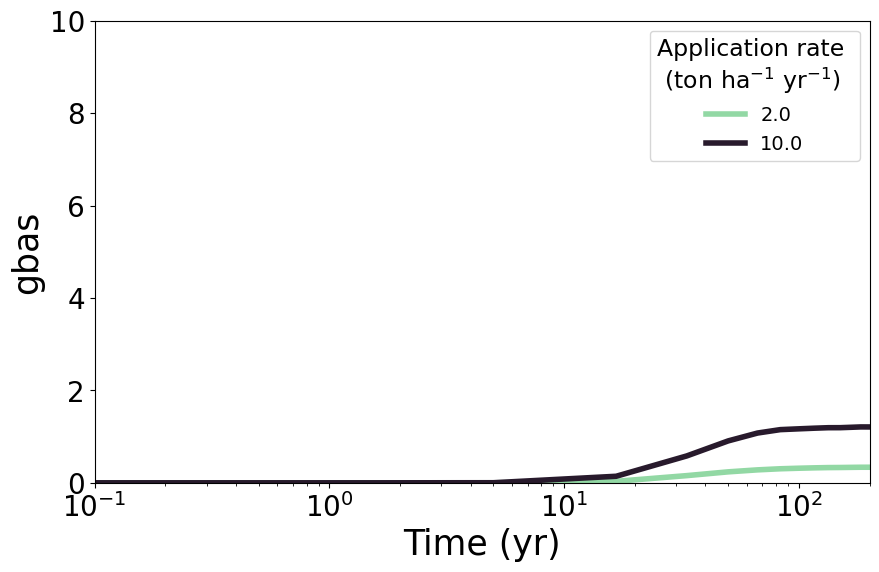

In [7]:
# --- PLOT poro percent over time 
# set data conditions
var = "gbas"
feedstock = "gbas"
dustrad = 50
depth = 0.15
logX = True
logY = False
overflow_pt = 50
dustrate_min = 2
dustrate_max = 60

# pull out the data we want 
if feedstock == dustsp1:
    dsp1 = dsfs1c.sel(dustrad = dustrad, depth=depth, method='nearest').sel(dustrate_ton_ha_yr = slice(dustrate_min, dustrate_max))[var]
elif feedstock == dustsp2:
    dsp1 = dsfs2c.sel(dustrad = dustrad, depth=depth, method='nearest').sel(dustrate_ton_ha_yr = slice(dustrate_min, dustrate_max))[var]
else:
    raise ValueError("Feedstock is not one of the prescribed dustsp!")

# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dsp1 = dsp1.interpolate_na(dim='time', method='linear').copy()

# *****************************
# --- plot aesthetics
# color palette
col = cmo.deep
overflow_col = 'black'
# line
lwd = 4
lwd_overflow = 2
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = 3,12
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (0.1 if logX else 0), 200
ymin, ymax = 0, 10
# legend
fs_legtitle = 17
fs_legtxt = 14
# *****************************

# ------- PLOT ----------------
# get colormap
colors = col(np.linspace(0.2, 1, len(dsp1.dustrate_ton_ha_yr.values)))  # Generate colors for each dust

fig, ax = plt.subplots(figsize=(10,6))
ax.axhline(y=overflow_pt, color=overflow_col, linestyle="--", linewidth=lwd_overflow)
for i, dustrate in enumerate(dsp1.dustrate_ton_ha_yr.values):
    ax.plot(dsp1.time, dsp1.sel(dustrate_ton_ha_yr=dustrate), 
    label=f"{dustrate}", color=colors[i], linewidth=lwd)

ax.set_xlabel("Time (yr)", fontsize=fs_xlab)
ax.set_ylabel(var, fontsize=fs_ylab)
ax.tick_params(axis='both', labelsize=fs_tick)
(ax.set_xscale('log') if logX else "")
(ax.set_yscale('log') if logY else "")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.legend(title=f"Application rate \n {r'$(\text{ton}\ \text{ha}^{-1}\ \text{yr}^{-1})$'}", title_fontsize=fs_legtitle, fontsize=fs_legtxt, loc="best")
plt.show();




## Depth profile over time

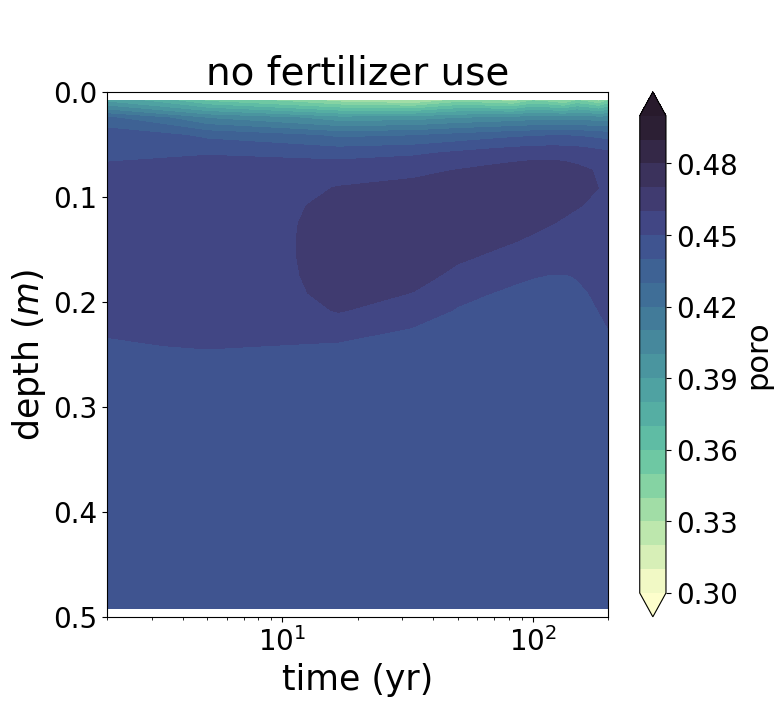

In [11]:
# --- PLOT --------------------
# set data conditions
var = "poro"
feedstock = "gbas"
dustrad = 50
logX = True
logY = False
overflow_pt = 0.30
dustrate = 60
contourline_threshold = 0.25 

# pull out the data we want 
if feedstock == dustsp1:
    dsp1 = dsfs1b.sel(dustrad = dustrad, dustrate_ton_ha_yr = dustrate, method='nearest')[var]
elif feedstock == dustsp2:
    dsp1 = dsfs2b.sel(dustrad = dustrad, dustrate_ton_ha_yr = dustrate, method='nearest')[var]
else:
    raise ValueError("Feedstock is not one of the prescribed dustsp!")


# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dsp1 = dsp1.interpolate_na(dim='depth', method='linear').copy()
# dsp2 = dsp2.interpolate_na(dim='depth', method='linear').copy()


# *****************************
# --- plot aesthetics
# color palette
col = cmo.deep
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = 0.3,0.5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 200
ymin, ymax = 0.5, 0
# *****************************

# x and y arrays
# [fs 1]
x1 = dsp1['time'].values
y1 = dsp1['depth'].values



# normalize color scale to center at zero
# norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=contourline_threshold)
# norm = mcolors.LogNorm(vmin=dsp1.min(), vmax=dsp1.max())
norm = None

# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

# --- fs 1
ax = plt.subplot(spec[0])
contour = plt.contourf(x1,y1, dsp1, 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x1*2,y1,dsp1,levels=[contourline_threshold], colors='black', linewidths=2)
plt.xlabel(r"time (yr)", fontsize=fs_xlab)
plt.ylabel(r"depth $(m)$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.suptitle(f"netCDR basalt — aglime\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
plt.title(f"\n{fertLevel_1} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cbar = plt.colorbar(contour)
cbar.set_label(f"{var}", fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)



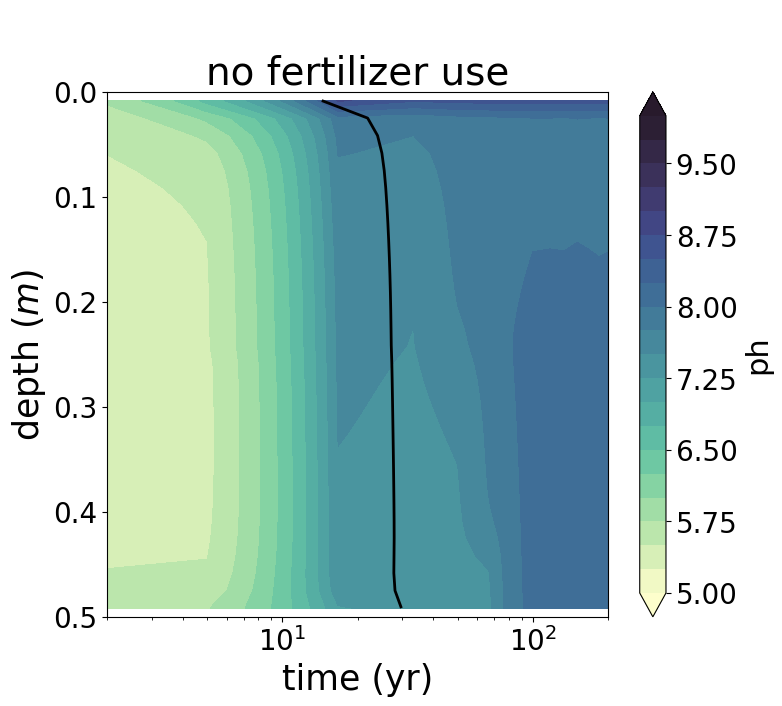

In [13]:
# --- PLOT --------------------
# set data conditions
var = "ph"
feedstock = "gbas"
dustrad = 50
logX = True
logY = False
overflow_pt = 8.5
dustrate = 60
contourline_threshold = 7 


# pull out the data we want 
if feedstock == dustsp1:
    dsp1 = dsfs1e.sel(dustrad = dustrad, dustrate_ton_ha_yr = dustrate, method='nearest')[var]
elif feedstock == dustsp2:
    dsp1 = dsfs2e.sel(dustrad = dustrad, dustrate_ton_ha_yr = dustrate, method='nearest')[var]
else:
    raise ValueError("Feedstock is not one of the prescribed dustsp!")


# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dsp1 = dsp1.interpolate_na(dim='depth', method='linear').copy()
# dsp2 = dsp2.interpolate_na(dim='depth', method='linear').copy()


# *****************************
# --- plot aesthetics
# color palette
col = cmo.deep
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = 5,10
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 200
ymin, ymax = 0.5, 0
# *****************************

# x and y arrays
# [fs 1]
x1 = dsp1['time'].values
y1 = dsp1['depth'].values



# normalize color scale to center at zero
# norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=contourline_threshold)
# norm = mcolors.LogNorm(vmin=dsp1.min(), vmax=dsp1.max())
norm = None

# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

# --- fs 1
ax = plt.subplot(spec[0])
contour = plt.contourf(x1,y1, dsp1, 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x1*2,y1,dsp1,levels=[contourline_threshold], colors='black', linewidths=2)
plt.xlabel(r"time (yr)", fontsize=fs_xlab)
plt.ylabel(r"depth $(m)$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.suptitle(f"netCDR basalt — aglime\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
plt.title(f"\n{fertLevel_1} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cbar = plt.colorbar(contour)
cbar.set_label(f"{var}", fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)



In [88]:
dsfs1d

<xarray.Dataset> Size: 29kB
Dimensions:             (depth: 30, dustrate_ton_ha_yr: 5, dustrad: 2)
Coordinates:
  * depth               (depth) float64 240B 0.0008333 0.0025 ... 0.0475 0.04917
  * dustrate_ton_ha_yr  (dustrate_ton_ha_yr) float64 40B 0.0 2.0 10.0 40.0 60.0
  * dustrad             (dustrad) int32 8B 25 50
    time                float64 8B ...
Data variables:
    na                  (dustrate_ton_ha_yr, dustrad, depth) float64 2kB ...
    k                   (dustrate_ton_ha_yr, dustrad, depth) float64 2kB ...
    no3                 (dustrate_ton_ha_yr, dustrad, depth) float64 2kB ...
    mg                  (dustrate_ton_ha_yr, dustrad, depth) float64 2kB ...
    ca                  (dustrate_ton_ha_yr, dustrad, depth) float64 2kB ...
    ph                  (dustrate_ton_ha_yr, dustrad, depth) float64 2kB ...
    na_coredep          (dustrate_ton_ha_yr, dustrad, depth) float64 2kB ...
    k_coredep           (dustrate_ton_ha_yr, dustrad, depth) float64 2kB ...
    no3_coredep         (dustrate_ton_ha_yr, dustrad, depth) float64 2kB ...
    mg_coredep          (dustrate_ton_ha_yr, dustrad, depth) float64 2kB ...
    ca_coredep          (dustrate_ton_ha_yr, dustrad, depth) float64 2kB ...
    ph_coredep          (dustrate_ton_ha_yr, dustrad, depth) float64 2kB ...
Attributes:
    outfile:  prof_aq

In [92]:
dsp1

<xarray.DataArray 'ph' (depth: 30)> Size: 240B
array([9.78518311, 9.78518311, 9.78518311, 9.78518311, 9.78518311,
       9.78518311, 9.78518311, 9.78518311, 9.78518311, 9.78518311,
       9.78518311, 9.78518311, 9.78518311, 9.78518311, 9.78518311,
       9.78518311, 9.78518311, 9.78518311, 9.78518311, 9.78518311,
       9.78518311, 9.78518311, 9.78518311, 9.78518311, 9.78518311,
       9.78518311, 9.78518311, 9.78518311, 9.78518311, 9.78518311])
Coordinates:
  * depth               (depth) float64 240B 0.0008333 0.0025 ... 0.0475 0.04917
    dustrate_ton_ha_yr  float64 8B 40.0
    dustrad             int32 4B 50
    time                float64 8B 100.0
Attributes:
    units:    mol/L

/tmp/ipykernel_23048/1361563249.py:79: UserWarning: Adding colorbar to a different Figure <Figure size 2000x1500 with 3 Axes> than <Figure size 2000x1500 with 1 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(contour)


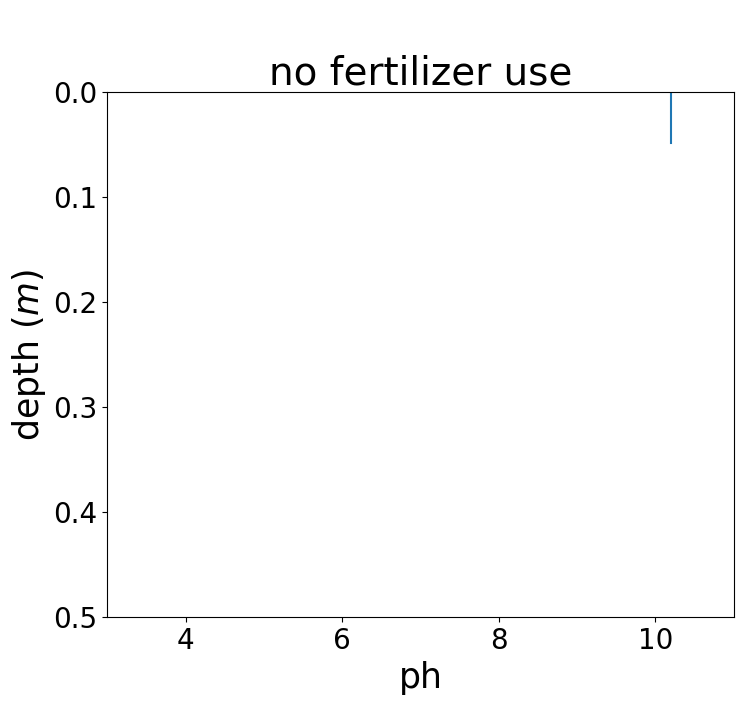

In [14]:
# --- PLOT --------------------
# set data conditions
var = "ph"
feedstock = "gbas"
dustrad = 50
logX = False
logY = False
overflow_pt = 0.30
dustrate = 40
contourline_threshold = 7 


# pull out the data we want 
if feedstock == dustsp1:
    dsp1 = dsfs1d.sel(dustrad = dustrad, dustrate_ton_ha_yr = dustrate, method='nearest')[var]
elif feedstock == dustsp2:
    dsp1 = dsfs2d.sel(dustrad = dustrad, dustrate_ton_ha_yr = dustrate, method='nearest')[var]
else:
    raise ValueError("Feedstock is not one of the prescribed dustsp!")


# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dsp1 = dsp1.interpolate_na(dim='depth', method='linear').copy()
# dsp2 = dsp2.interpolate_na(dim='depth', method='linear').copy()


# *****************************
# --- plot aesthetics
# color palette
col = cmo.deep
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = 0.3,0.5
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 3), 11
ymin, ymax = 0.5, 0
# *****************************

# x and y arrays
# [fs 1]
x1 = dsp1['time'].values
y1 = dsp1['depth'].values



# normalize color scale to center at zero
# norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=contourline_threshold)
# norm = mcolors.LogNorm(vmin=dsp1.min(), vmax=dsp1.max())
norm = None

# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

# --- fs 1
ax = plt.subplot(spec[0])
plt.plot(dsp1, y1)
# contour = plt.contourf(x1,y1, dsp1, 
#                         levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
# contour_line = plt.contour(x1*2,y1,dsp1,levels=[contourline_threshold], colors='black', linewidths=2)
plt.xlabel(r"ph", fontsize=fs_xlab)
plt.ylabel(r"depth $(m)$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.suptitle(f"netCDR basalt — aglime\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
plt.title(f"\n{fertLevel_1} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
cbar = plt.colorbar(contour)
cbar.set_label(f"{var}", fontsize=fs_cbarlab)
cbar.ax.tick_params(labelsize=fs_cbartick)



In [15]:
# --- PLOT --------------------
# set data conditions
var = "base_saturation"
feedstock = "gbas"
dustrad = 50
time = 50
logX = True
logY = False
contourline_threshold = 7 

# pull out the data we want 
if feedstock == dustsp1:
    if varin == "soil_ph":   # then there's no time dim
        dsp1 = dsfs1.sel(dustrad = dustrad, method='nearest')[var]
    else:
        dsp1 = dsfs1.sel(dustrad = dustrad, time=time, method='nearest')[var]
elif feedstock == dustsp2:
    if varin == "soil_ph":     # then there's no time dim
        dsp1 = dsfs2.sel(dustrad = dustrad, method='nearest')[var]
    else:
        dsp1 = dsfs2.sel(dustrad = dustrad, time=time, method='nearest')[var]
else:
    raise ValueError("Feedstock is not one of the prescribed dustsp!")


# interpolate to fill nans (they're rare, 
# but present in a couple cases where a run didn't complete)
dsp1 = dsp1.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()
# dsp2 = dsp2.interpolate_na(dim='dustrate_ton_ha_yr', method='linear').copy()


# *****************************
# --- plot aesthetics
# color palette
col = cmo.deep
# set fontsizes
fs_xlab = 25     # x title
fs_ylab = 25     # y title
fs_tick = 20     # ticks, bot haxes
fs_title = 30    # plot title (main)
fs_title_sub = 28 # plot title (individual panels)
fs_cbarlab = 22  # colorbar title
fs_cbartick = 20 # colorbar ticks
# color limits
cmin, cmax = 3,12
cbar_extend = "both"    # both, max, or min
# axis limits
xmin, xmax = (2 if logX else 0), 100
ymin, ymax = 0.5, 0
# *****************************

# x and y arrays
# [fs 1]
x1 = dsp1['dustrate_ton_ha_yr'].values
y1 = dsp1['depth'].values


# normalize color scale to center at zero
# norm = TwoSlopeNorm(vmin=cmin, vmax=cmax,vcenter=contourline_threshold)
# norm = mcolors.LogNorm(vmin=dsp1.min(), vmax=dsp1.max())
norm = None

# --- SET UP PLOT
spec = GridSpec(ncols=2, nrows=2, hspace=0.2, width_ratios=[0.8, 1])
plt.figure(figsize=(20,15))

# --- fertlevel 1
ax = plt.subplot(spec[0])
contour = plt.contourf(x1,y1, dsp1.transpose(), 
                        levels=np.linspace(cmin, cmax, 21), cmap = col, norm=norm, vmin=cmin, vmax=cmax, extend=cbar_extend)
contour_line = plt.contour(x1,y1,dsp1.transpose(),levels=[contourline_threshold], colors='black', linewidths=2)
plt.xlabel(r"application flux $(\text{ton}\ \text{ha}^{-1}\ \text{yr}^{-1})$", fontsize=fs_xlab)
plt.ylabel(r"depth $(m)$", fontsize=fs_xlab)
plt.tick_params(axis='both', labelsize=fs_tick)
# plt.suptitle(f"netCDR basalt — aglime\ncf: {cf_apprate} {r'$ton\ ha^{-1}\ yr^{-1}$'}; {cf_dustrad*2} {r'$\mu m$'}", fontsize = fs_title)
plt.title(f"\n{fertLevel_1} fertilizer use", fontsize=fs_title_sub)
(plt.xscale('log') if logX else "")
(plt.yscale('log') if logY else "")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)


NameError: name 'varin' is not defined